In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

In [2]:
import jax
import torch

In [140]:
import sys
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/')
sys.path.append('/mnt/home/szheng/projects/util_code/')
sys.path.append('/mnt/home/szheng/projects/place_variability/code/')
import pca_analysis as pcaa

In [2]:
# create data
n_neurons_base = 10
n_neurons_repeat = 3
sep = 5

std = 5
n_pos = n_neurons_base * (sep )
mean_activity_base = np.zeros((n_neurons_base,n_pos))
for n in range(n_neurons_base):
    mean_activity_base[n,n*sep] = 1.
mean_activity_base_smooth = gaussian_filter1d(mean_activity_base,std,axis=1)
mean_activity_smooth = np.repeat(mean_activity_base_smooth,n_neurons_repeat,axis=0)

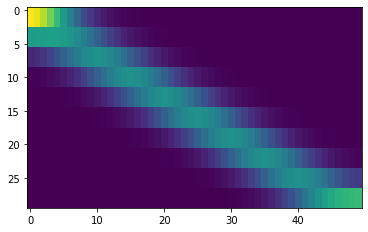

In [5]:
plt.imshow(mean_activity_smooth)

In [64]:
def get_tangent(X):
    X_diff = np.diff(X,axis=1)
    X_norm = X[:,:-1] / np.linalg.norm(X[:,:-1],axis=0,keepdims=True) # careful axis=0
    X_diff_proj_x = np.einsum('nt,nt->t',X_diff,X_norm)
    X_diff_proj_x_vec = X_diff_proj_x * X_norm
    tangent = X_diff - X_diff_proj_x_vec
    tangent = tangent / np.linalg.norm(tangent,axis=0,keepdims=True)
    # repeat last
    tangent = np.concatenate([tangent,tangent[:,[-1]]],axis=1)
    return tangent

def select_out_plane(x_in,additional_orthogonal_vec=None,n=1):
    n_neuron,n_cols = x_in.shape
    ns_vec_all = []
    for c in range(n_cols):
        x_in_one = x_in[:,[c]]
        if additional_orthogonal_vec is not None:
            additiona_one= additional_orthogonal_vec[:,[c]]
            x_in_one = np.concatenate([x_in_one,additiona_one],axis=1)
#         x_in = np.concatenate([x_in,additional_orthogonal_vec],axis=1)
        null_space = scipy.linalg.null_space(x_in_one.T,rcond=1e-25)
        n_null = null_space.shape[1]
        inds = np.random.choice(np.arange(n_null),n)
        ns_vec = null_space[:,inds].T # n x n_neurons
        ns_vec_all.append(ns_vec) 
    ns_vec_all = np.stack(ns_vec_all,axis=-1)
        
    return ns_vec_all # n x n_neurons x n_pos



In [29]:
mean_activity_smooth.shape

(30, 50)

In [30]:
tangent.shape

(30, 50)

# get all directions

In [73]:
n_ortho = 1
tangent = get_tangent(mean_activity_smooth)
tangent_direction = tangent[None,:,:]
ns_vec_all = select_out_plane(mean_activity_smooth,additional_orthogonal_vec=tangent,n=n_ortho)
mean_direction = mean_activity_smooth / np.linalg.norm(mean_activity_smooth,axis=0,keepdims=True)
mean_direction = mean_direction[None,:,:]
directions = np.concatenate([mean_direction,tangent_direction,ns_vec_all],axis=0)

In [75]:
directions.shape

(3, 30, 50)

# combine to create trial to trial variability

### generate weights

In [176]:
n_trials = 100
noise_scale = 1
n_directions = directions.shape[0]
noise_amp_across_pos_trial = np.random.normal(size=(n_directions,n_pos,n_trials)) * noise_scale
w_tangent = np.ones((1,n_pos)) * 1
w_mean = np.ones((1,n_pos)) * 0
w_ortho = np.ones((n_ortho,n_pos)) * 0
w = np.concatenate([w_mean,w_tangent,w_ortho],axis=0) # n_directions x n_pos
w = w / np.sum(w,axis=0,keepdims=True) * noise_scale

### combine weights and directions and signal mean

In [177]:
noise_times_dir=np.einsum('dpt,dnp->dnpt',noise_amp_across_pos_trial,directions) # d-direction,p-position,t-trial,n-neuron
final_noise=np.einsum('dp,dnpt->npt',w,noise_times_dir)

In [179]:
X = mean_activity_smooth[:,:,None] + final_noise

In [160]:
from sklearn.decomposition import PCA

In [189]:
pca=PCA(n_components=2)
# X_mean = mean_activity_smooth
X_mean = X.mean(axis=-1)
loadings=pca.fit_transform(X_mean.T)

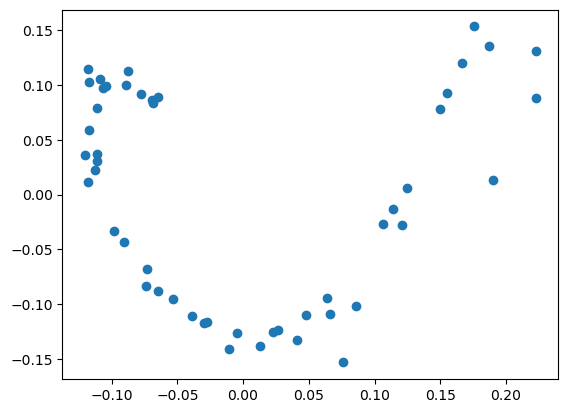

In [190]:
plt.scatter(loadings[:,0],loadings[:,1])

In [191]:
X_flat=X.swapaxes(0,2).reshape(-1,X.shape[0]).T

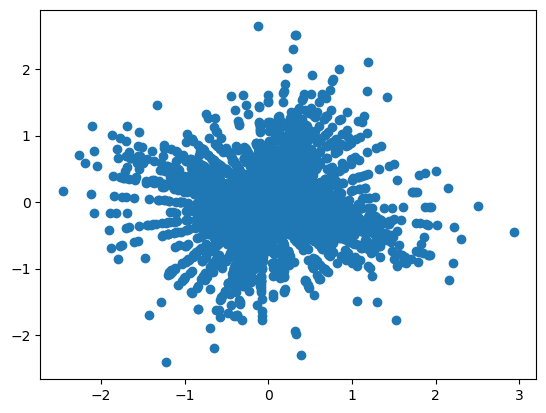

In [192]:
pca=PCA(n_components=2)
loadings=pca.fit_transform(X_flat.T)
plt.scatter(loadings[:,0],loadings[:,1])

In [167]:
X_flat = X.swapaxes(1,2).swapaxes(0,1).shape
X_flat = np.reshape()

(100, 30, 50)

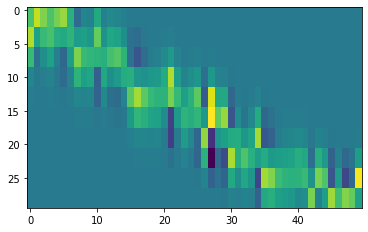

In [136]:
plt.imshow(X[:,:,0])

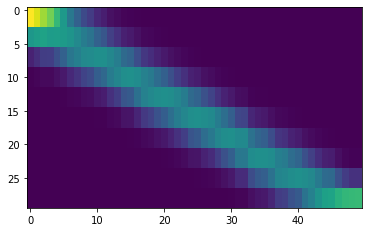

In [129]:
plt.imshow(X.mean(axis=-1))

In [93]:
final_noise.shape

(30, 50, 10)

In [79]:
w.shape

(3, 50)

In [67]:
ns_vec_all.shape

(1, 30, 50)

In [62]:
ns_vec_all.shape

(30, 1, 50)

In [61]:
tangent.shape

(30, 50)

In [53]:
np.linalg.norm(mean_direction,axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [49]:
np.linalg.norm(mean_activity_smooth,axis=0)

array([0.31415134, 0.30595336, 0.29088548, 0.27131839, 0.25015618,
       0.23020777, 0.21358929, 0.20130918, 0.19324964, 0.18853024,
       0.1860245 , 0.18483228, 0.18430481, 0.18409867, 0.1840339 ,
       0.18401307, 0.18400016, 0.18398773, 0.18398726, 0.18399778,
       0.18400433, 0.18399775, 0.18398711, 0.18398711, 0.18399775,
       0.18400433, 0.18399775, 0.18398711, 0.18398711, 0.18399775,
       0.18400432, 0.18399772, 0.18398699, 0.18398662, 0.183999  ,
       0.18400823, 0.18400892, 0.18401646, 0.18405773, 0.18418726,
       0.18439251, 0.18472594, 0.18523755, 0.18595303, 0.18683808,
       0.18777033, 0.18861614, 0.18927161, 0.1896965 , 0.1898994 ])

In [43]:
ns_vec_all[:,0,5]

array([-1.43878822e-04,  1.03596967e-03,  1.76601159e-04, -2.00819618e-04,
       -2.00819618e-04, -2.00819618e-04, -4.23116878e-04, -4.23116878e-04,
       -4.23116878e-04, -1.71438656e-04, -1.71438656e-04, -1.71438656e-04,
       -2.16967496e-05, -2.16967496e-05, -2.16967496e-05, -9.36389999e-07,
       -9.36389999e-07,  9.99999064e-01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00])

In [179]:
tangent

array([[-0.24716963, -0.25512664, -0.27181975, ...,  0.        ,
         0.        ,  0.        ],
       [-0.24716963, -0.25512664, -0.27181975, ...,  0.        ,
         0.        ,  0.        ],
       [-0.24716963, -0.25512664, -0.27181975, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.22104788,
         0.18166706,  0.15357873],
       [ 0.        ,  0.        ,  0.        , ...,  0.22104788,
         0.18166706,  0.15357873],
       [ 0.        ,  0.        ,  0.        , ...,  0.22104788,
         0.18166706,  0.15357873]])

In [11]:
x_in.shape

(30, 100)

In [31]:
x_in = mean_activity_smooth
additional_orthogonal_vec = tangent
n_neuron,n_cols = x_in.shape
ns_vec_all = []
for c in range(n_cols):
    x_in_one = x_in[:,[c]]
    if additional_orthogonal_vec is not None:
        additiona_one= additional_orthogonal_vec[:,[c]]
        x_in_one = np.concatenate([x_in_one,additiona_one],axis=1)
#         x_in = np.concatenate([x_in,additional_orthogonal_vec],axis=1)
    null_space = scipy.linalg.null_space(x_in_one.T,rcond=1e-25)
    n_null = null_space.shape[1]
    inds = np.random.choice(np.arange(n_null),n)
    ns_vec = null_space[:,inds] # n_neurons x n
    ns_vec_all.append(ns_vec) 
ns_vec_all = np.stack(ns_vec_all,axis=-1)

In [33]:
ns_vec_all.shape

(30, 9, 50)

In [12]:
x_in = mean_activity_smooth[:,[0]]
# x_in = mean_activity_smooth
additional_orthogonal_vec = tangent[:,[0]]
# additional_orthogonal_vec = tangent
n_neuron,n_cols = x_in.shape
if additional_orthogonal_vec is not None:
    x_in = np.concatenate([x_in,additional_orthogonal_vec],axis=1)
null_space = scipy.linalg.null_space(x_in.T,rcond=1e-25)
n_null = null_space.shape[1]
inds = np.random.choice(np.arange(n_null),n)
ns_vec = null_space[:,inds]

In [15]:
ns_vec.shape

(30, 9)

In [175]:
ns_vec[:,2].dot(x_in)

array([ 4.03251872e-18, -1.89799755e-16])

In [169]:
ns_vec.shape

(30, 9)

In [161]:
null_space

array([], shape=(2, 0), dtype=float64)

In [154]:
ns_vec.shape

(99, 9)

In [144]:
tangent.dot(ns_vec)

ValueError: shapes (30,49) and (50,1) not aligned: 49 (dim 1) != 50 (dim 0)

In [98]:
X_diff = np.diff(X,axis=1)
X_norm = X[:,:-1] / np.linalg.norm(X[:,:-1],axis=0,keepdims=True)
X_diff_proj_x = np.einsum('nt,nt->t',X_diff,X_norm)
X_diff_proj_x_vec = X_diff_proj_x * X_norm
tangent = X_diff - X_diff_proj_x_vec
tangent = tangent / np.linalg.norm(tangent,axis=0,keepdims=True)

In [83]:
X_diff_proj_x_vec[:,0]

array([-3.53891702e-03, -3.53891702e-03, -3.53891702e-03, -2.41911680e-03,
       -2.41911680e-03, -2.41911680e-03, -5.61988849e-04, -5.61988849e-04,
       -5.61988849e-04, -4.30721724e-05, -4.30721724e-05, -4.30721724e-05,
       -8.45741680e-07, -8.45741680e-07, -8.45741680e-07, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00])

In [94]:
a

array([5.02952917e-01, 5.02952917e-01, 5.02952917e-01, 2.77684174e-01,
       2.77684174e-01, 2.77684174e-01, 5.69592657e-02, 5.69592657e-02,
       5.69592657e-02, 4.33944355e-03, 4.33944355e-03, 4.33944355e-03,
       8.52045351e-05, 8.52045351e-05, 8.52045351e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

In [95]:
X_norm[:,0]

array([4.71524563e-01, 4.71524563e-01, 4.71524563e-01, 3.22322616e-01,
       3.22322616e-01, 3.22322616e-01, 7.48792765e-02, 7.48792765e-02,
       7.48792765e-02, 5.73892723e-03, 5.73892723e-03, 5.73892723e-03,
       1.12686444e-04, 1.12686444e-04, 1.12686444e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

In [93]:
X_diff[:,0].dot(X_norm[:,0])

-0.007505265470847119

In [91]:
X_diff_proj_x[0]

-0.007505265470847121

In [86]:
diff.dot(a)

-0.008300740093155295

In [81]:
diff.dot(a) * a

array([-4.17488145e-03, -4.17488145e-03, -4.17488145e-03, -2.30498415e-03,
       -2.30498415e-03, -2.30498415e-03, -4.72804061e-04, -4.72804061e-04,
       -4.72804061e-04, -3.60205931e-05, -3.60205931e-05, -3.60205931e-05,
       -7.07260701e-07, -7.07260701e-07, -7.07260701e-07, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00])

In [73]:
a = X[:,0]

In [75]:
a = a / np.linalg.norm(a)

In [77]:
diff=X_diff[:,0]

In [78]:
(diff - diff.dot(a) * a).dot(a)

-2.2768245622195593e-18

In [48]:
np.einsum('nt,nt->t',(X_diff - X_diff_proj_x_vec) , X[:,:-1])

array([-2.35033306e-03, -4.28922938e-03, -5.43891651e-03, -5.67743633e-03,
       -5.14774486e-03, -4.16003793e-03, -3.05128634e-03, -2.07000541e-03,
       -1.33582009e-03, -8.61038053e-04, -5.82304525e-04, -4.40564899e-04,
       -3.71779663e-04, -3.40717763e-04, -3.30111844e-04, -3.27596310e-04,
       -3.27954453e-04, -3.26175761e-04, -3.23776212e-04, -3.23794634e-04,
       -3.26123119e-04, -3.27530086e-04, -3.26063413e-04, -3.23748829e-04,
       -3.23785577e-04, -3.26123119e-04, -3.27530086e-04, -3.26063413e-04,
       -3.23748829e-04, -3.23785577e-04, -3.26125573e-04, -3.27540920e-04,
       -3.26107439e-04, -3.23565959e-04, -3.23411345e-04, -3.25056522e-04,
       -3.24750359e-04, -3.19458139e-04, -3.03748395e-04, -2.88418835e-04,
       -2.61575754e-04, -2.20380325e-04, -1.64325214e-04, -9.97766614e-05,
       -4.36560371e-05, -2.07822695e-06,  2.19673710e-05,  3.07896293e-05,
        2.48493196e-05])

In [40]:
X_diff[:,0] == (X[:,1] - X[:,0])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [101]:
tangent[:,0].dot(mean_activity_smooth[:,0])

-9.71445146547012e-17

In [ ]:
noise_direction_signal = mean_activity_smooth / np.linalg.norm(mean_activity_smooth,axis=1,keepdims=True)
noise_direction_tangent = np.diff(mean_activity_smooth,axis=1) 
noise_direction_tangent = 

In [13]:
mean_activity_smooth.shape

(30, 50)

In [12]:
noise_per_trial = np.

NameError: name 'noise_per_trial' is not defined

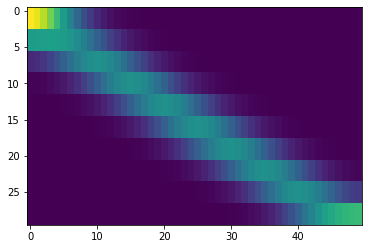

In [10]:
%matplotlib inline
plt.imshow(mean_activity_smooth,aspect='auto')